In [99]:
## Import the modules/packages/libraries required
## Importing packages

import numpy as np
import rasterio

import pandas as pd
import xarray as xr
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.plot
import pyproj
from rasterio.crs import CRS



import matplotlib.pyplot as plt
import geopandas as gpd

## Clipping
from rasterio.mask import mask
from shapely.geometry import mapping
import fiona

from datetime import timedelta

#from rasterstats import zonal_stats


In [78]:
## Define a function to determine the UTM zone and create final CRS string accordingly
def determine_utm_crs(df):
    #df = gpd.read_file(shapefile_path)
    # Calculate the centroid of the geometries
    df['Center_point'] = df['geometry'].centroid
    # Extract latitude and longitude from the centroid
    lon = df['Center_point'].x.iloc[0]
    lat = df['Center_point'].y.iloc[0]
    
    # Determine N or S latitude zone
    lat_zone = 'N' if lat >= 0 else 'S'
    
    # UTM zones for the conterminous United States
    if -138 <= lon < -132:
        zone = '08'
    elif -132 <= lon < -126:
        zone = '09'
    elif -126 <= lon < -120:
        zone = '10'
    elif -120 <= lon < -114:
        zone = '11'
    elif -114 <= lon < -108:
        zone = '12'
    elif -108 <= lon < -102:
        zone = '13'
    elif -102 <= lon < -96:
        zone = '14'
    elif -96 <= lon < -90:
        zone = '15'
    elif -90 <= lon < -84:
        zone = '16'
    elif -84 <= lon < -78:
        zone = '17'
    elif -78 <= lon < -72:
        zone = '18'
    elif -72 <= lon < -66:
        zone = '19'
    elif -66 <= lon < -60:
        zone = '20'
    else:
        return "Location is outside the specified range for conterminous US."

    # Create the CRS string using the UTM zone and latitude zone
    crs_string = f'EPSG:326{zone}' if lat_zone == 'N' else f'EPSG:327{zone}'
    return crs_string


# Define a function to create folders
def ResultsFolder(Folder):
    if not os.path.exists(Folder):
        os.makedirs(Folder)


### Reproject to dst_crs = 'EPSG:4326'

def reproject_tiff (Input_tiff_file, output_tiff_file, Resampling_technique):
    # Open the input TIFF
    with rasterio.open(Input_tiff_file) as src:
        # Define the target CRS to EPSG:4326
        dst_crs = 'EPSG:4326'
        
        # Calculate the transformation needed to reproject
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        
        # Define metadata for the output TIFF
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Reproject and save the output TIFF
        with rasterio.open(output_tiff_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling_technique)

## Define a function to clip a ratser using shapefile
def clip_raster_with_shapefile_func(raster_path, output_path, shapefile_path):
    with fiona.open(shapefile_path) as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]
            
    with rasterio.open(raster_path) as src:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta.copy()
            print("Metadata before updating")
            print(out_meta)
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "nodata":0
                            })
            print("\n\n\nMetadata after updating")      
            print(out_meta)
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)
                
    print("Raster clipping complete.")


#3 Reclassification function using Lookup Array
def reclassify_raster(reprojected_raster_filename, lookup,output_filename):
    """
    Reclassify the raster data based on the provided lookup array.

    Parameters:
    - reprojected_raster_filename: str, path to the reprojected raster file.
    - lookup: np.array, an array where index corresponds to old value and value at that index is the new value.

    """
    with rasterio.open(reprojected_raster_filename, 'r', masked=True) as src:
        # Read as numpy array
        array = src.read(1)  # Read the first band
        profile = src.profile
        
        print(f'The unique values before reclassification are: {np.unique(array)}')
        
        # Apply the lookup to reclassify the raster data
        array = lookup[array]
        
        print(f'The unique values after reclassification are: {np.unique(array)}')
        
        # Output the value and count of each unique class in the reclassified array
        unique, counts = np.unique(array, return_counts=True)
        print(f'The value and count are:')
        print(np.asarray((unique, counts)).T)
        print('\n\n')
        
        # Save the reclassified raster
        #output_filename = 'reclassified_' + reprojected_raster_filename
        with rasterio.open(output_filename, 'w', **profile) as dst:
            dst.write(array, 1)


## Function to create CN grid
def create_cn_grid(landuse_raster_path, soil_raster_path, output_file, folder_name, site_id):
    """
    Create a CN grid using soil and land use data.
    
    Parameters:
    - landuse_raster_path: str, path to the land use raster file.
    - soil_raster_path: str, path to the soil raster file.
    - output_file: str, filename for the output CN grid.
    - folder_name: str, directory to store the output file.
    - site_id: str, identifier for the site being processed.
    """
    # Read land use and soil data
    with rasterio.open(landuse_raster_path) as landuse_src:
        landuse_data = landuse_src.read(1)
        landuse_profile = landuse_src.profile

    with rasterio.open(soil_raster_path) as soil_src:
        soil_data = soil_src.read(1)
        soil_profile = soil_src.profile

    # Ensure both rasters have the same dimensions
    assert landuse_data.shape == soil_data.shape, "Land use and soil rasters must have the same dimensions"

    # Create an empty CN grid with a default value (e.g., -9999)
    cn_grid = np.full_like(landuse_data, -9999, dtype=np.int16)

    # Define CN values for specific land use and soil type combinations
    cn_values = {
    (1, 1): 100, (1, 2): 100, (1, 3): 100, (1, 4): 100,  # Water bodies
    (2, 1): 57, (2, 2): 72, (2, 3): 81, (2, 4): 86,      # Open Space
    (3, 1): 30, (3, 2): 58, (3, 3): 71, (3, 4): 78,      # Forest
    (4, 1): 67, (4, 2): 77, (4, 3): 83, (4, 4): 87,      # Barren Land
    (1, 5): 30, (2, 5): 55, (3, 5): 70, (4, 5): 77,      # Forest
    (1, 6): 39, (2, 6): 61, (3, 6): 74, (4, 6): 80,      # Meadows
    (1, 7): 39, (2, 7): 61, (3, 7): 74, (4, 7): 80,      # Pasture
    (1, 8): 67, (2, 8): 78, (3, 8): 85, (4, 8): 88,      # Row crops
    (1, 9): 35, (2, 9): 50, (3, 9): 60, (4, 9): 70       # Wetlands
}

    # Use NumPy indexing to fill the CN grid with values from the dictionary
    for (land_use_code, soil_code), cn_value in cn_values.items():
        mask = (landuse_data == land_use_code) & (soil_data == soil_code)
        cn_grid[mask] = cn_value

    print(f'Unique CN values in the grid: {np.unique(cn_grid)}')

    # Specify the output CN grid file
    output_path = f'{folder_name}/results_{site_id}/cngrid_{site_id}.tif'

    # Write the CN grid to a new raster
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=cn_grid.shape[0],
        width=cn_grid.shape[1],
        count=1,
        dtype=rasterio.int16,
        crs=landuse_profile['crs'],
        transform=landuse_profile['transform'],
        nodata=-9999
    ) as dst:
        dst.write(cn_grid, 1)

    print(f'CN grid calculated and saved to {output_path}')
##
## The function gives directly the zonnal CN value for the watershed
def calculate_watershed_cn(landuse_raster_path, soil_raster_path, watershed_shapefile):
    """
    Calculate the average Curve Number (CN) for a watershed based on land use and soil data.

    Parameters:
    - landuse_raster_path: str, path to the land use raster file.
    - soil_raster_path: str, path to the soil raster file.
    - watershed_shapefile: str, path to the watershed boundary shapefile.
    """
    # Load the watershed shapefile
    print(watershed_shapefile)
    watershed = gpd.read_file(watershed_shapefile)

    # Clip land use and soil data to the watershed
    with rasterio.open(landuse_raster_path) as landuse_src:
        landuse_data, landuse_transform = mask(landuse_src, watershed.geometry, crop=True)
        landuse_meta = landuse_src.meta.copy()

    with rasterio.open(soil_raster_path) as soil_src:
        soil_data, soil_transform = mask(soil_src, watershed.geometry, crop=True)
        soil_meta = soil_src.meta.copy()
    # Ensure both clipped rasters have the same dimensions
    assert landuse_data.shape == soil_data.shape, "Clipped land use and soil rasters must have the same dimensions"

    # Create an empty CN grid with a default value (e.g., -9999)
    cn_grid = np.full(landuse_data.shape[1:], -9999, dtype=np.int16)

    # Define CN values for specific land use and soil type combinations
    cn_values = {
    (1, 1): 100, (1, 2): 100, (1, 3): 100, (1, 4): 100,  # Water bodies
    (2, 1): 57, (2, 2): 72, (2, 3): 81, (2, 4): 86,      # Open Space
    (3, 1): 30, (3, 2): 58, (3, 3): 71, (3, 4): 78,      # Forest
    (4, 1): 67, (4, 2): 77, (4, 3): 83, (4, 4): 87,      # Barren Land
    (1, 5): 30, (2, 5): 55, (3, 5): 70, (4, 5): 77,      # Forest
    (1, 6): 39, (2, 6): 61, (3, 6): 74, (4, 6): 80,      # Meadows
    (1, 7): 39, (2, 7): 61, (3, 7): 74, (4, 7): 80,      # Pasture
    (1, 8): 67, (2, 8): 78, (3, 8): 85, (4, 8): 88,      # Row crops
    (1, 9): 35, (2, 9): 50, (3, 9): 60, (4, 9): 70       # Wetlands
}

    # Use NumPy indexing to fill the CN grid with values from the dictionary
    for (land_use_code, soil_code), cn_value in cn_values.items():
        mask1 = (landuse_data[0] == land_use_code) & (soil_data[0] == soil_code)
        cn_grid[mask1] = cn_value

    # Calculate zonal statistics for the CN grid to get the mean CN value for the watershed
    cn_grid_masked = np.ma.masked_values(cn_grid, -9999)  # Mask the nodata values
    mean_cn = np.mean(cn_grid_masked)

    # Check if mean_cn is a masked constant
    if np.ma.is_masked(mean_cn):
        print("No valid CN data found; all values are masked.")
        return None

    # Round the mean CN to the nearest integer
    rounded_cn = round(float(mean_cn))  # Convert to float first to handle MaskedConstant
    return rounded_cn




## Define function to resample raster
def resample_raster(input_raster_file, reference_raster_file, output_raster_file):
    with rasterio.open(reference_raster_file) as ref:
        ref_data = ref.read(1)  # Read the first band from the reference raster
        kwargs = ref.meta.copy()  # Copy the metadata from the reference raster

        with rasterio.open(input_raster_file) as src:
            src_data = src.read(1)  # Read the first band from the source raster
            resampled_data = np.empty_like(ref_data)  # Create an empty array like the reference data

            # Reproject the source data to the reference data's spatial parameters
            reproject(
                source=src_data,
                destination=resampled_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                resampling=Resampling.nearest  # Using nearest neighbor resampling
            )

            # Update the kwargs for the output raster to reflect changes
            kwargs.update({
                'dtype': 'float32',  # Ensure dtype matches what's needed for your application
                'count': 1,
                'height': resampled_data.shape[0],
                'width': resampled_data.shape[1]
            })

            # Write the resampled data to the output raster file
            with rasterio.open(output_raster_file, 'w', **kwargs) as dst:
                dst.write(resampled_data, 1)

## Function for zonal statistics-
#from rasterstats import zonal_stats

def calculate_zonal_cn(shapefile_path, cn_raster_path):
    stats = zonal_stats(shapefile_path, cn_raster_path, stats=["mean", "max", "min"])
    print(stats)

In [ ]:
clip_raster_with_shapefile_func(raster_path, output_path, shapefile_path)

## <span style="color:green"> Reading the Soil and land cover raster data and Reclassification</span> 

In [6]:
# Define your NoData value
nodata_value = 0  # Replace with your preferred NoData value

# Load land use and soil rasters
with rasterio.open(LU_data) as landuse_raster:
    landuse_data = landuse_raster.read(1)
    
    # Set NoData values
    nodata_mask = landuse_data == landuse_raster.nodata
    landuse_data = landuse_data.astype(float)
    landuse_data[nodata_mask] = nodata_value
    # Get the shape of the raster (number of rows, number of columns)
    rows, cols = landuse_raster.shape
    print(f"The raster has {rows} rows and {cols} columns.")

print(np.unique(landuse_data))


## Soil
with rasterio.open(Soil_data) as soil_raster:
    soil_data = soil_raster.read(1)
    
    # Get the shape of the raster (number of rows, number of columns)
    rows, cols = soil_raster.shape
    print(f"The raster has {rows} rows and {cols} columns.")
    
    # Set NoData values
    nodata_mask = soil_data == soil_raster.nodata
    soil_data = soil_data.astype(float)
    soil_data[nodata_mask] = nodata_value
    
print(np.unique(soil_data))

The raster has 20595 rows and 33257 columns.
[ 0. 11. 21. 22. 23. 24. 31. 41. 42. 43. 52. 71. 81. 82. 90. 95.]
The raster has 959 rows and 1739 columns.
[0. 1. 2. 3. 4. 5. 6. 7.]


In [8]:
## The original NLCD raster contains values rangaing from 0 to 255

## Build a "lookup array" where the original value is replaced
## by the reclassified value. Setting all of the reclassified values is cheap 
## because the memory is only allocated once for the lookup array.
lookup = np.arange(256, dtype=np.uint8)

print("The lookup array created using numpy")
print(lookup)
print("\n\n")


                                                         # Unclassified (0)

lookup[np.where((11 <= lookup) & (lookup <= 12)) ] = 1   # Open Water (11), Perennial Snow/ Ice (12) as 'water bodies' (1)
lookup[np.where(lookup == 21) ] = 2                      # Developed Open Space (21) as 'open space' (2)
lookup[np.where((22 <= lookup) & (lookup <= 24)) ] = 3   # Low (22), Medium (23) and High Intensity (24) as 'Urban' (3)
lookup[np.where(lookup == 31) ] = 4                      # Barren Land (31) as 'Barren land' (4)
lookup[np.where((41 <= lookup) & (lookup <= 43)) ] = 5   # Deciduous (41), Evergreen (42) and Mixed (43) Forests as 'Forest' (5)
lookup[np.where((51 <= lookup) & (lookup <= 52)) ] = 6   # Shrubs (52)   as 'Meadows'(6)
lookup[np.where((71 <= lookup) & (lookup <= 74)) ] = 6   # Herbaceous (71) as 'Meadows'(6)
lookup[np.where(lookup == 81) ] = 7                      # Hay/Pasture (81)  as 'Pasture' (7)
lookup[np.where(lookup == 82) ] = 8                      # Cultivated Crops (82) as 'Row crops' (8)
lookup[np.where((90 <= lookup) & (lookup <= 95)) ] = 9   # Woody Wetlands (90) and Emergent Herbaceous Wetlands (95) as 'Wetlands' (9)

print("The lookup array modified for reclassification")
print(lookup)

The lookup array created using numpy
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2

In [9]:
## Lookup table for soil raster reclassification
lookup_soil = np.arange(256, dtype=np.uint8)

print("The lookup array created using numpy")
print(lookup_soil)
print("\n\n")


                                                         # Unclassified (0)
lookup_soil[np.where(lookup_soil == 1) ] = 1             # Soil Type 'A'
lookup_soil[np.where(lookup_soil == 2) ] = 1             # Soil Type 'A/B'
lookup_soil[np.where(lookup_soil == 3) ] = 2             # Soil Type 'B'
lookup_soil[np.where(lookup_soil == 4) ] = 2             # Soil Type 'B/C'
lookup_soil[np.where(lookup_soil == 5) ] = 3             # Soil Type 'C'
lookup_soil[np.where(lookup_soil == 6) ] = 3             # Soil Type 'C/D'
lookup_soil[np.where(lookup_soil == 7) ] = 4             # Soil Type 'D'


print("The lookup array modified for reclassification")
print(lookup_soil)

The lookup array created using numpy
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 2

In [ ]:
reclassify_raster(reprojected_raster_filename, lookup,output_filename)

In [11]:
### importing the sol and LU files
# Path to the reprojected raster
Soil_data = f'C:/Users/mgalib/Box/GRA_work/Database/Tennesse/Soil/States_data/SOIL_TENNESSE_reproj.tif'

LU_data = 'C:/Users/mgalib/Box/GRA_work/Database/Tennesse/Land_cover/NLCD_Tenesse/reproject/NLCD_2016_Land_Cover_Reprojected.tiff'
Soil_reclass_output = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Soil/Soil_TN_reclass.tiff"
LU_reclass_output = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_TN_reclass.tiff"
Soil_reclass =reclassify_raster(Soil_data, lookup_soil,Soil_reclass_output)
LU_reclass =reclassify_raster(LU_data, lookup,LU_reclass_output)

The unique values before reclassification are: [0 1 2 3 4 5 6 7]
The unique values after reclassification are: [0 1 2 3 4]
The value and count are:
[[     0 621475]
 [     1  94700]
 [     2 402436]
 [     3 214399]
 [     4 334691]]



The unique values before reclassification are: [ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]
The unique values after reclassification are: [0 1 2 3 4 5 6 7 8 9]
The value and count are:
[[        0 131478731]
 [        1  10788593]
 [        2  31788333]
 [        3  26761534]
 [        4   1266232]
 [        5 288341261]
 [        6  24352310]
 [        7  90199279]
 [        8  57827380]
 [        9  22124262]]





The raster has 959 rows and 1739 columns.


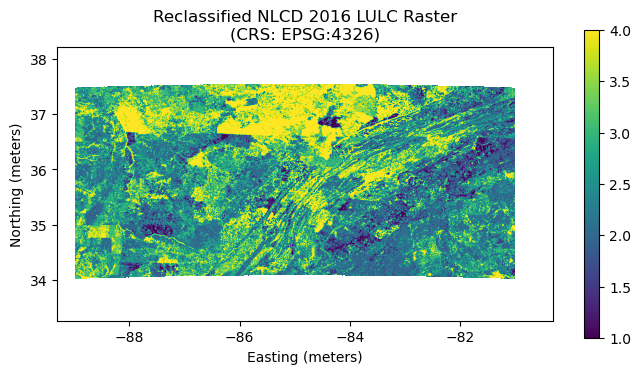

In [15]:
nlcd_year=2016
with rasterio.open(Soil_reclass_output) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5)
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(f'Reclassified NLCD {nlcd_year} LULC Raster\n(CRS: {src.crs})')
    # Get the shape of the raster (number of rows, number of columns)
    rows, cols = src.shape
    print(f"The raster has {rows} rows and {cols} columns.")


The raster has 20595 rows and 33257 columns.


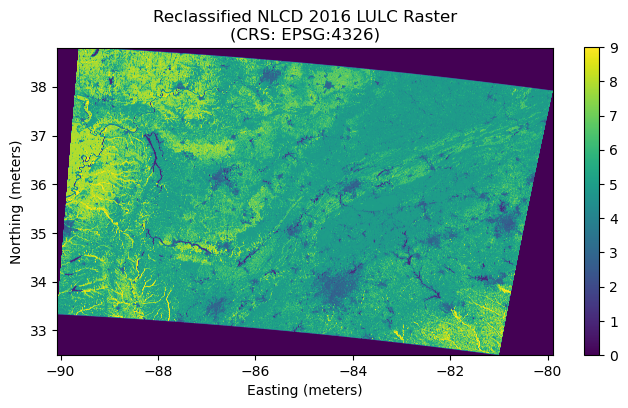

In [16]:
nlcd_year=2016
with rasterio.open(LU_reclass_output) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5)
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(f'Reclassified NLCD {nlcd_year} LULC Raster\n(CRS: {src.crs})')
    # Get the shape of the raster (number of rows, number of columns)
    rows, cols = src.shape
    print(f"The raster has {rows} rows and {cols} columns.")


In [63]:
## Resampling NLCD LU data-
Soil_reclass = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Soil/Soil_TN_reclass.tiff"
#LU_reclass = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_TN_reclass.tiff"
LU_resample_output = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_TN_reclass_resample.tiff"
#LU_reclass = resample_raster(LU_reclass, Soil_reclass, LU_resample_output)

In [159]:
import pandas as pd
import os
from datetime import timedelta

def create_event_file(base_folder, final_events_folder, watershed_csv, shapefiles_folder, landuse_raster_path, soil_raster_path, output_folder):
    # Read the watershed extent data to get the area information
    watershed_data = pd.read_csv(watershed_csv)
    
    # Process each folder in the 'Hyetograph' base folder
    for folder_name in os.listdir(base_folder):
        if folder_name.startswith('Results_Rainfall_'):
            parts = folder_name.split('_')
            gauge_no = parts[2]
            start_date = parts[3]

            try:
                # Read rainfall data from the specific folder
                rainfall_csv_path = os.path.join(base_folder, folder_name, 'rainfall_mean.csv')
                rainfall_data = pd.read_csv(rainfall_csv_path)
                # Convert Date_2 to consistent datetime format
                rainfall_data['Date_2'] = pd.to_datetime(rainfall_data['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
                rainfall_data = rainfall_data.rename(columns={'rainfall_in': 'Rainfall_in'})
                
                # Prepare to collect all flood events matching the criteria
                all_flood_events = []

                # Search corresponding flood event file in 'Final-events' folder
                for file_name in os.listdir(final_events_folder):
                    if file_name.startswith('Flood_Event_') and file_name.endswith(f'{gauge_no}.csv'):
                        flood_event_path = os.path.join(final_events_folder, file_name)
                        flood_event_data = pd.read_csv(flood_event_path)
                        # Convert Date1 to consistent datetime format without timezone
                        flood_event_data['Date1'] = pd.to_datetime(flood_event_data['datetimeUTC']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')
                        
                        # Adjust the date_min condition check
                        min_date = pd.to_datetime(flood_event_data['Date1']).min() - timedelta(days=5)
                        if min_date.strftime('%Y-%m-%d') == start_date:
                            flood_event_data = flood_event_data[['Date1', 'discharge_cfs']]
                            flood_event_data.rename(columns={'discharge_cfs': 'Discharge_cfs'}, inplace=True)
                            all_flood_events.append(flood_event_data)

                # Concatenate all matching flood events dataframes
                if all_flood_events:
                    flood_event_dataframe = pd.concat(all_flood_events)
                    event_data = pd.concat([rainfall_data[['Date_2', 'Rainfall_in']], flood_event_dataframe], axis=1)
                else:
                    event_data = rainfall_data[['Date_2', 'Rainfall_in']]

                # Additional data handling
                gauge_no = int(gauge_no)
                event_data['Area'] = watershed_data.loc[watershed_data['Gauge_No'] == gauge_no, 'Area (sq_miles)'].values[0]
                shapefile_path = os.path.join(shapefiles_folder, f'shape_0{gauge_no}.shp')
                CN = calculate_watershed_cn(landuse_raster_path, soil_raster_path, shapefile_path)
                if CN is None:  # If CN calculation fails, skip to the next file
                    print(f"Skipping {gauge_no} due to CN calculation error.")
                    continue
                event_data['CN'] = CN
                
                # Save to CSV in the specified output folder
                output_csv_path = os.path.join(output_folder, f'Event_{gauge_no}_{start_date}.csv')
                event_data.to_csv(output_csv_path, index=False)
                print(f'CSV file saved: {output_csv_path}')
            
            except Exception as e:
                print(f"Error processing {folder_name}: {e}")


In [161]:
# Usage of the function
base_folder = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Hyetograph"
final_events_folder = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Final_events"
watershed_csv = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/watershed_extent_TN.csv"
shapefiles_folder = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites"
landuse_raster_path ="C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_TN_reclass_resample.tiff"
soil_raster_path ="C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Soil/Soil_TN_reclass.tiff"
output_folder = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN"

create_event_file(base_folder, final_events_folder, watershed_csv, shapefiles_folder, landuse_raster_path, soil_raster_path, output_folder)


C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites\shape_03426385.shp
CSV file saved: C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN\Event_3426385_2000-03-28.csv
C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites\shape_03426385.shp
CSV file saved: C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN\Event_3426385_2000-04-01.csv
Error processing Results_Rainfall_3426385_2003-08-06: Reindexing only valid with uniquely valued Index objects
C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites\shape_03426385.shp
CSV file saved: C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN\Event_3426385_2007-03-28.csv
C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites\shape_03426385.shp
CSV file saved: C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN\Event_3426385_2008-08-19.csv
C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Shapefiles_sites\shape_03426385.shp
CSV file saved: C:/Users/mgalib/Box/Fi

In [152]:
import pandas as pd
import numpy as np

# Create two Series with different lengths
data1 = pd.Series([1, 2, 3, 4, 5], name='Column1')
data2 = pd.Series([10, 20, 30, 40, 50, 60], name='Column2')

# Concatenate the two series into a DataFrame along the columns
df = pd.concat([data1, data2], axis=1)

print(df)

   Column1  Column2
0      1.0       10
1      2.0       20
2      3.0       30
3      4.0       40
4      5.0       50
5      NaN       60


In [170]:
landuse_raster_path ="C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_TN_reclass_resample.tiff"
output_LU = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/LU/LU_watershed_TN.tiff"
soil_raster_path ="C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Soil/Soil_TN_reclass.tiff"
output_soil ="C:/Users/mgalib/Box/Finley_UH_work/Data/TN/Soil/Soil_watershed_TN.tiff"


# Example usage
shapefiles_folder = "C:/Users/mgalib/Box/Finley_UH_work/Data/TN/shapefile_TN"
shp_path = os.path.join(shapefiles_folder, f'shapefileTN.shp')
clip_raster_with_shapefile_func(soil_raster_path, output_soil, shp_path)

Metadata before updating
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1739, 'height': 959, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.005177321928710444, 0.0, -89.31358098903877,
       0.0, -0.005177321928710444, 38.21970353300633)}



Metadata after updating
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0, 'width': 1481, 'height': 329, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.005177321928710444, 0.0, -89.31358098903877,
       0.0, -0.005177321928710444, 36.68203892017933)}
Raster clipping complete.


The raster has 329 rows and 1481 columns.


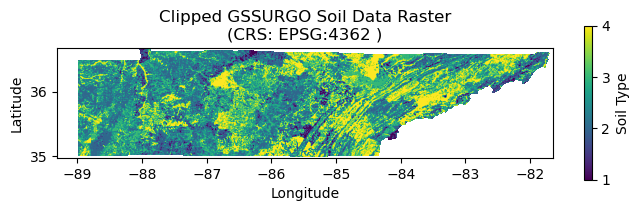

In [182]:
with rasterio.open(output_soil) as src:
    nlcd_year =2016
    # Read as numpy array
    array = src.read()
    profile = src.profile
    
    fig, ax = plt.subplots(figsize = (8,4))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Soil Type',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Clipped GSSURGO Soil Data Raster\n(CRS: EPSG:4362 )")
    
    # Get the shape of the raster (number of rows, number of columns)
    rows, cols = src.shape
    print(f"The raster has {rows} rows and {cols} columns.")



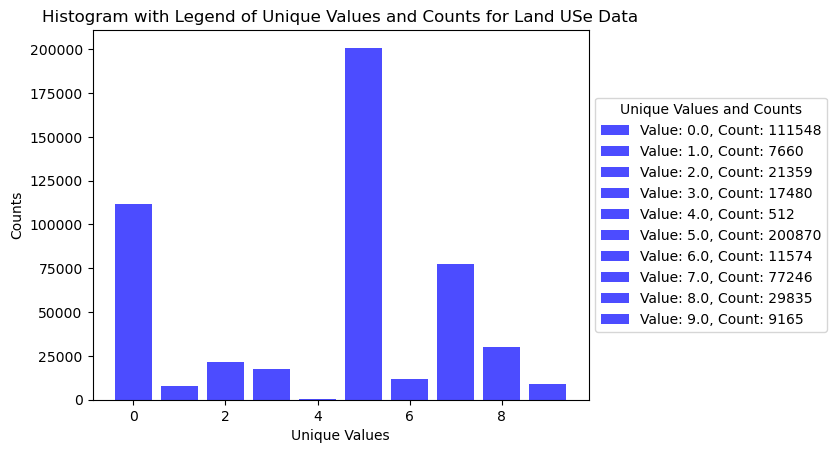

In [178]:
def plot_raster_with_legend(output_soil):
    with rasterio.open(output_soil) as src:
        data = src.read(1)  # Assuming it's a single-band raster

        # Extract unique values and their counts
        unique_values, counts = np.unique(data, return_counts=True)
        
        fig, ax = plt.subplots()
    
        # Create a bar plot
        bars = ax.bar(unique_values, counts, align='center', color='blue', alpha=0.7)

        # Add legend with unique values
        labels = [f'Value: {val}, Count: {count}' for val, count in zip(unique_values, counts)]
        ax.legend(bars, labels, title='Unique Values and Counts',loc='center left', bbox_to_anchor=(1, 0.5))

        ax.set_xlabel('Unique Values')
        ax.set_ylabel('Counts')
        ax.set_title('Histogram with Legend of Unique Values and Counts for Land USe Data')

        plt.show()

plot_raster_with_legend(output_LU)